In [2]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ,get_json_from_file

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/Data"


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants
import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json

from IPython.display import display, HTML


14:24:01: Debug: Adding duplicate image handler for 'Windows bitmap file'
14:24:01: Debug: Adding duplicate animation handler for '1' type
14:24:01: Debug: Adding duplicate animation handler for '2' type
14:24:02: Debug: Adding duplicate image handler for 'Windows bitmap file'
14:24:02: Debug: Adding duplicate animation handler for '1' type
14:24:02: Debug: Adding duplicate animation handler for '2' type


In [3]:
################
# Start FSLeyes (very neat tool to visualize MRI data of all sorts) within Python
################
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()


(ipykernel_launcher.py:581): Gtk-CRITICAL **: 14:25:20.965: gtk_window_resize: assertion 'height > 0' failed
14:25:22: Debug: ScreenToClient cannot work when toplevel window is not shown
14:25:22: Debug: ScreenToClient cannot work when toplevel window is not shown
14:25:22: Debug: ScreenToClient cannot work when toplevel window is not shown
14:25:22: Debug: ScreenToClient cannot work when toplevel window is not shown
14:25:22: Debug: ScreenToClient cannot work when toplevel window is not shown
14:25:22: Debug: ScreenToClient cannot work when toplevel window is not shown
14:25:22: Debug: ScreenToClient cannot work when toplevel window is not shown
14:25:22: Debug: ScreenToClient cannot work when toplevel window is not shown
14:25:22: Debug: ScreenToClient cannot work when toplevel window is not shown
14:25:22: Debug: ScreenToClient cannot work when toplevel window is not shown
14:25:22: Debug: ScreenToClient cannot work when toplevel window is not shown


In [4]:
import subprocess

dataset_id = 'ds000171'
subject = '01'

sample_path = "/home/jovyan/data/dataset"
mkdir_no_exist(sample_path)
bids_root = op.join(os.path.abspath(""),sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

fmap_path = op.join(bids_root, 'sub-control01', 'func')
subject_dir = 'sub-control{}'.format(subject)

##################
# Solution
# There are two solutions
# The easiest is simply to include all data of subject-01
# The other is to add one line for the fieldmaps
##################
# Change the command below to include files in the fmap subdirectory
# You should STILL be loading the EPI and anatomical

# Simple variant to include everything from subject-01
subprocess.run(["openneuro-py", "download", "--dataset", dataset_id, # Openneuro has for each dataset a unique identifier
                "--target-dir", bids_root,  # The path where we want to save our data. You should save your data under /home/jovyan/Data/[your dataset ID] to be 100% fool-proof
                "--include", subject_dir # Effectively get all data
               ], check=True)


👋 Hello! This is openneuro-py 2024.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds000171 …


📁 Traversing directories for ds000171 : 18 entities [00:09,  2.00 entities/s]


📥 Retrieving up to 15 files (5 concurrent downloads). 


sub-control01_T1w.nii.gz:   0%|          | 0.00/8.77M [00:00<?, ?B/s]
dataset_description.json:   0%|          | 0.00/2.79k [00:00<?, ?B/s]
                                                                     
README:   0%|          | 0.00/0.98k [00:00<?, ?B/s]

CHANGES:   0%|          | 0.00/45.0 [00:00<?, ?B/s]
                                                   

                                                   
participants.tsv:   0%|          | 0.00/1.63k [00:00<?, ?B/s]
sub-control01_T1w.nii.gz:   1%|          | 82.5k/8.77M [00:00<00:19, 472kB/s]
sub-control01_task-music_run-1_events.tsv: 0.00B [00:00, ?B/s]
sub-control01_T1w.nii.gz:   2%|▏         | 150k/8.77M [00:00<00:22, 399kB/s] 
sub-control01_task-music_run-2_events.tsv:   0%|          | 0.00/339 [00:00<?, ?B/s]
                                                                                    
sub-control01_task-music_run-2_bold.nii.gz:   0%|          | 0.00/33.9M [00:00<?, ?B/s]

sub-control01_T1w.nii.gz:   2%|▏        

✅ Finished downloading ds000171.
 
🧠 Please enjoy your brains.
 


CompletedProcess(args=['openneuro-py', 'download', '--dataset', 'ds000171', '--target-dir', '/home/jovyan/data/dataset/ds000171', '--include', 'sub-control01'], returncode=0)

In [5]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- sub-control01/
|------ anat/
|--------- sub-control01_T1w.nii.gz
|------ func/
|--------- sub-control01_task-music_run-1_bold.nii.gz
|--------- sub-control01_task-music_run-1_events.tsv
|--------- sub-control01_task-music_run-2_bold.nii.gz
|--------- sub-control01_task-music_run-2_events.tsv
|--------- sub-control01_task-music_run-3_bold.nii.gz
|--------- sub-control01_task-music_run-3_events.tsv
|--------- sub-control01_task-nonmusic_run-4_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-4_events.tsv
|--------- sub-control01_task-nonmusic_run-5_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-5_events.tsv


In [10]:
import os.path as op

# Set the root of the BIDS dataset
#bids_root_demo = 'data/dataset/ds000171/sub-control01/ds000171'  # Update this to the actual path

# Reset overlays in FSLeyes
fsleyesDisplay.resetOverlays()

# Load a specific functional file
fsleyesDisplay.load(op.join('dataset/ds000171/sub-control01/func', 'sub-control01_task-music_run-1_bold.nii.gz'))


Text(0, 0.5, 'Mean voxel intensity')

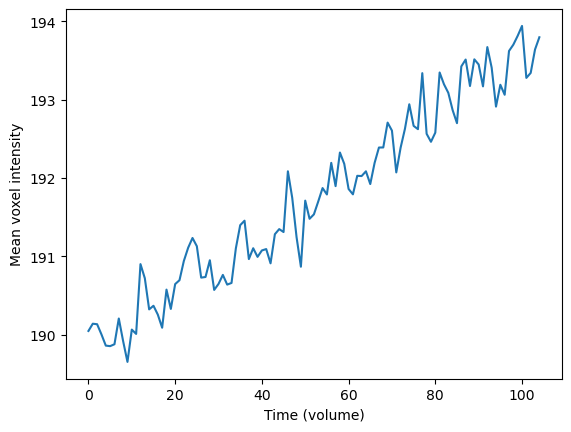

In [11]:
import matplotlib.pyplot as plt
import nibabel as nib

plt.plot(nib.load(op.join('dataset/ds000171/sub-control01/func', 'sub-control01_task-music_run-1_bold.nii.gz')).get_fdata().mean(axis=(0,1,2)))
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')

In [10]:
import os
import numpy as np
import nibabel as nib
import glob
import os.path as op
import subprocess
from nilearn.image import smooth_img
from nilearn.image import new_img_like

# Define paths
dataset_id = 'ds000171'
subject = 'control01'
sample_path = "/home/jovyan/Mini_Project_1/dataset"
bids_root = op.join(os.path.abspath(""), sample_path, dataset_id)
subject_dir = f'sub-{subject}'
func_dir = op.join(bids_root, subject_dir, 'func')

# Find all music-related functional runs
music_runs = sorted(glob.glob(op.join(func_dir, f'{subject_dir}_task-music_run-*_bold.nii.gz')))

if len(music_runs) == 0:
    raise FileNotFoundError("No music runs found!")

# Helper function to standardize each run (z-scoring)
def standardize_data(data):
    mean_data = np.mean(data, axis=-1, keepdims=True)
    std_data = np.std(data, axis=-1, keepdims=True)
    std_data[std_data == 0] = 1  # Avoid division by zero
    standardized_data = (data - mean_data) / std_data
    return standardized_data

# Initialize a list to store paths of preprocessed runs
preprocessed_runs = []

# Preprocessing for each run
for run in music_runs:
    # Load the run data using nibabel
    img = nib.load(run)
    data = img.get_fdata()

    # Step 1: Motion Correction
    mc_run_path = run.replace('.nii.gz', '_mc.nii.gz')
    subprocess.run(['mcflirt', '-in', run, '-out', mc_run_path, '-refvol', '0', '-plots'], check=True)

    # Step 2: Smoothing
    smoothed_img_path = mc_run_path.replace('.nii.gz', '_smoothed.nii.gz')
    smoothed_img = smooth_img(mc_run_path, fwhm=6)  # 6mm smoothing
    nib.save(smoothed_img, smoothed_img_path)

    # Load smoothed data
    smoothed_data = smoothed_img.get_fdata()

    # Step 3: Standardize the smoothed data (z-scoring)
    standardized_data = standardize_data(smoothed_data)

    # Save the standardized data as a new NIfTI file
    standardized_img = new_img_like(smoothed_img, standardized_data)
    standardized_img_path = smoothed_img_path.replace('.nii.gz', '_standardized.nii.gz')
    nib.save(standardized_img, standardized_img_path)

    # Append the path of the standardized run
    preprocessed_runs.append(standardized_img_path)

# Step 4: Concatenate the standardized runs
all_runs_data = []
for run in preprocessed_runs:
    img = nib.load(run)
    all_runs_data.append(img.get_fdata())

# Concatenate along the time dimension
concatenated_data = np.concatenate(all_runs_data, axis=-1)

# Save the concatenated data into a new NIfTI file
new_img = nib.Nifti1Image(concatenated_data, img.affine)
output_file = op.join(func_dir, f'{subject_dir}_task-music_allruns_bold_concat_preprocessed.nii.gz')
nib.save(new_img, output_file)

print(f"Preprocessed and concatenated runs saved as {output_file}")


Preprocessed and concatenated runs saved as /home/jovyan/Mini_Project_1/dataset/ds000171/sub-control01/func/sub-control01_task-music_allruns_bold_concat_preprocessed.nii.gz


Data shape: (80, 80, 50, 105)


ValueError: Expected 3D data for plotting slices.